## Clustering

Let's now retrieve the clustering embeddings from the chromadb and perform clustering on them.

In [1]:
import chromadb

client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection("nomic_clustering_v1")

Let's retrieve the embeddings and the words along with the class, division, and section from the chromadb and create a dataframe with them.


In [2]:
import pandas as pd

# Retrieve the embeddings, words, and metadata
words = collection.get(include=["embeddings", "documents"])['documents']
embeddings = collection.get(include=["embeddings", "documents"])['embeddings']
metadata = collection.get(include=["embeddings", "documents", "metadatas"])['metadatas']

# Create a dataframe with the embeddings and the words
clustering_df = pd.DataFrame({'word': words, 'embedding': embeddings})

# Add the class, division, and section from metadata to the dataframe
clustering_df['class'] = [md['class'] for md in metadata]
clustering_df['division'] = [md['division'] for md in metadata]
clustering_df['section'] = [md['section'] for md in metadata]

clustering_df

,word,embedding,class,division,section
0,Existence,"[-0.000911712646484375, -0.007648468017578125,...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
1,Inexistence,"[0.006107330322265625, 0.0400390625, -0.014945...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
2,Consanguinity,"[0.0592041015625, 0.006099700927734375, -0.005...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,RELATION
3,Trisection,"[0.0188751220703125, 0.01338958740234375, -0.0...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,NUMBER
4,Innocence,"[0.046478271484375, 0.022918701171875, -0.0289...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
...,...,...,...,...,...
1052,Knave,"[-0.004238128662109375, 0.0267791748046875, -0...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1053,Disinterestedness,"[0.0007662773132324219, 0.0261688232421875, -0...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1054,Selfishness,"[0.0265655517578125, 0.0660400390625, -0.03088...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1055,Virtue,"[0.041351318359375, 0.0128173828125, -0.041320...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS


Let's have a look at the class distribution.

In [3]:
clustering_df['class'].value_counts()

class
WORDS RELATING TO THE VOLUNTARY POWERS             228
WORDS EXPRESSING ABSTRACT RELATIONS                193
WORDS RELATING TO THE SENTIENT AND MORAL POWERS    184
WORDS RELATING TO THE INTELLECTUAL FACULTIES       163
WORDS RELATING TO MATTER                           147
WORDS RELATING TO SPACE                            142
Name: count, dtype: int64

We can see that the classes are well not balanced.

Let's now proceed to get the count of unique classes, which we will need for the clustering.

In [4]:
n_classes = clustering_df['class'].nunique()

## We will use the KMeansConstrained algorithm to perform the clustering.

The KMeansConstrained algorithm is a modified version of the KMeans algorithm that allows for a minimum and maximum number of words in each cluster, 
in order for the clusters to be 'balanced'.
We will use the `KMeansConstrained` algorithm from the `k_means_constrained` library to perform the clustering.

In [5]:
from k_means_constrained import KMeansConstrained

model = KMeansConstrained(n_clusters=n_classes, size_min=140, size_max=245,
                          n_init=100, max_iter=500, random_state=22, n_jobs=-1)  #22 min=140, max=245


We will use the embeddings to fit the model, and then we will add the cluster labels to the dataframe,
where we will use `vstack` to convert the list of embeddings into a matrix.

In [6]:
import numpy as np

matrix = np.vstack(clustering_df.embedding.values)
matrix.shape

(1057, 768)

We can now fit the model and add the cluster labels to the dataframe.

In [7]:
model.fit(matrix)
labels = model.labels_
clustering_df["Cluster"] = labels

We can now create a function to visualize the clusters in a 2D space using t-SNE.

t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

We will use the `TSNE` algorithm from the `sklearn.manifold` library to perform the t-SNE and then we will use the `matplotlib` library to visualize the clusters.

The following code was inspired by the following [OpenAI notebook](https://cookbook.openai.com/examples/clustering)

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def draw_clusters(clustering_df, title, num_categories, matrix):
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    colors = ["purple", "green", "red", "blue", "orange", "yellow", "cyan", "magenta", "brown", "gray"]
    # Ensure there are enough colors for the number of categories
    if num_categories > len(colors):
        raise ValueError("Number of categories exceeds the number of available colors")

    for category in range(num_categories):
        color = colors[category]
        xs = np.array(x)[clustering_df.Cluster == category]
        ys = np.array(y)[clustering_df.Cluster == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean() if xs.size > 0 else 0
        avg_y = ys.mean() if ys.size > 0 else 0

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

    plt.title(title)
    plt.show()

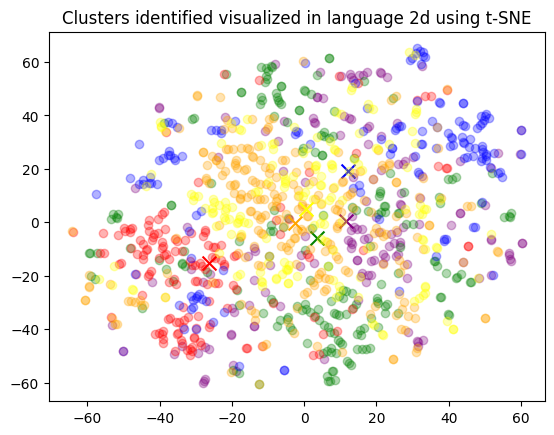

In [38]:
draw_clusters(clustering_df, "Clusters identified visualized in language 2d using t-SNE", n_classes, matrix)

Let's now count the number of elements in each cluster.

In [9]:
clustering_df.Cluster.value_counts()

Cluster
4    245
5    202
3    170
1    149
0    149
2    142
Name: count, dtype: int64

### Let's now try and give a name to each cluster based on the words that are in it.

For this task we will use the latest mistral-v.0.2 LLM model self-hosted using Ollama.
More specifically, we will give the model the words in each cluster and ask it to give a category name similar to the 
class names of the roget thesaurus. 
In order to use the model, we will use the `ChatOllama` class from the `langchain_community` library.
We will set the temperature to 0.0 to get the most likely categories and we will use the GPU if it is available.

In [11]:
from langchain_community.chat_models import ChatOllama
import torch

llm_model = 'mistral'
device = "cuda" if torch.cuda.is_available() else "cpu"

# We set the temperature to 0.0 to get the most likely categories and we use the mistral model
llm = ChatOllama(model=llm_model, temperature=0.0, device=device)

Next we will define the prompt that we will use to get the categories from the model.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    "Provide a category that classifies all these words about what they express (only into one category) : {words}"
    "similar with the naming of the following categories: {categories} along with a small explanation of why you chose to name the category in this way. At the end of the explanation, you must write the category again inside <<>>. For example: <<category>>")

Then we will create a chain that will use the prompt, the llm model and the output parser to get the categories from the model.

In [13]:
from langchain_core.output_parsers import StrOutputParser

chain = prompt | llm | StrOutputParser()

Now let us get the words along with their classes and division and sections from the json file we created earlier for later use.

In [9]:
import json

with open("hierarchy.json", "r") as f:
    categories = json.load(f)

Having the above setup, we can now get the categories for each cluster.

The following code was inspired by the following [OpenAI notebook](https://cookbook.openai.com/examples/clustering).

The idea is to use the words in each cluster to get the categories from the model
 and we will show 20 words from each cluster after the explanation about why the naming of the category was chosen,
 but here we are using the mistral model instead of the GPT-4 model through the langchain_community library.

In our case we will use the words in each cluster to get the categories from the model.
 and we will show 20 words from each cluster after the explanation about why the naming of the category was chosen.
 
More specifically, we will write the name of the category in the following format: <<category>> at the end of the explanation
in order to easily get it through regex.

In [15]:
import re

# Reading words belonging to each cluster
num_words = 10

# Initialize the list of classes
classes = []

for i in range(6):
    print(f"Cluster {i} Theme:", end=" ")

    words = ",".join(
        clustering_df[clustering_df.Cluster == i]["word"]
        .values
    )

    response = chain.invoke({"words": words, "categories": clustering_df['class'].unique()})
    print(response)

    # Extracting the categories from the response
    pattern = r'<<([^>]*)>>'
    matches = re.finditer(pattern, response)
    # Append extracted class name to the list of classes
    classes.append([match.group(1) for match in matches])
    sample_cluster_rows = clustering_df[clustering_df.Cluster == i]['word'].sample(num_words, random_state=42)
    for j in range(num_words):
        print(sample_cluster_rows.iloc[j], end=", ")
    print()

    print("-" * 100)

Cluster 0 Theme:  The given words express various abstract concepts and relationships. I would suggest naming this category as "Abstract Relations and Concepts" or simply "Abstract Concepts." This name is appropriate because it encompasses all the given words, which convey ideas that are not directly tied to physical objects or sensory experiences but rather represent abstract relationships, quantities, or concepts.

<<Abstract Concepts>>
Elevation, Futurity, Arrangement, Density, Evolution, Counteraction, Regression, Excitation, Insertion, Decrease, 
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  Based on the given words, I suggest the following category:

<<WORDS EXPRESSING PERCEPTUAL AND EXISTENTIAL QUALITIES>>

Explanation: The given words primarily express various perceptual and existential qualities, such as existence, sensory experiences (Sensualist, Gluttony, Drunkenness, etc.), spatial and temporal concept

Let's now see the classes that were extracted from the model.

In [16]:
classes

[['Abstract Concepts'],
 ['WORDS EXPRESSING PERCEPTUAL AND EXISTENTIAL QUALITIES'],
 ['WORDS RELATING TO EXISTENCE AND NON-EXISTENCE'],
 ['WORDS RELATING TO MORALITY AND LEGALITY'],
 ['WORDS EXPRESsing MORAL AND EMOTIONAL CONCEPTS'],
 ['WORDS RELATING TO THE SPIRITUAL AND MORAL DOMAIN']]

We can see that the model was able to give a category to each cluster based on the words that are in it.

Let's compare the extracted classes with the roget classes in terms of the naming of the categories.


#### Extracted Classes
They primarily focus on abstract, existential, moral, and spiritual concepts. 
These classes seem to delve into areas related to philosophy, ethics, and perhaps some elements of psychology or sociology. 
They deal with intangible aspects like morality, existence, and emotions, which are more subjective and philosophical in nature.

#### Roget Classes
This group of classes covers a wider range of topics. 
It includes classes on abstract relations (which could overlap with the ones that we got), but also expands into more concrete areas like matter and space. 
This group seems more diverse, including elements of philosophy (voluntary powers, intellectual faculties), 
but also delving into more scientific or physical realms (matter, space).
    
#### Similarity
- Both groups include classes that deal with abstract and philosophical concepts (e.g., 'Abstract Concepts' and 'WORDS EXPRESSING ABSTRACT RELATIONS').
- There is a focus on human faculties and capabilities in both, such as morality, intellect, and emotions.

#### Differences
1) The extracted classes are more focused on subjective, moral, and existential themes, 
while the roget classes have a broader scope that includes both abstract intellectual concepts and more tangible, physical themes (like matter and space).
2) The roget classes seem to integrate more elements of physical science or empirical study compared the extracted ones, 
which is more aligned with philosophical or ethical studies. 

Important to keep in mind is that the roget classes are based on the philosophical and psychological meaning of the words
according to the roget thesaurus, while the extracted classes are based on the meaning of the words according to the mistral-v.0.2 LLM model
which is a language model trained on a large corpus of text and is able to generate human-like text based on the input it receives.

#### Conclusion
The extracted classes seem to be more focused on abstract, existential, moral, and spiritual concepts,
while the roget classes have a broader scope that includes both abstract intellectual concepts and more tangible, physical themes,
and that may be due to the nature of the extracted classes being more subjective in nature and the roget classes being more diverse and inclusive of both abstract and concrete concepts because of the nature of the roget thesaurus.

Now done with the naming of the clusters, we can try and match the extracted classes with the classes from the roget thesaurus.

Let's start by creating a function that will take the extracted classes and the roget classes and will return the most similar roget class for each extracted class
by identifying the closest words to each cluster's centroid.

In [11]:
def clustering_details_optimized(model, maximum_value, df, hierarchy, category_index, isClass=True):
    centroids = model.cluster_centers_
    total_count = []

    for i, centroid in enumerate(centroids):
        cluster_df = df[df['Cluster'] == i]
        if cluster_df.empty:
            continue

        cluster_embeddings = np.vstack(cluster_df['embedding'])
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        closest_indices = np.argsort(distances)[:min(maximum_value, len(cluster_df))]
        closest_words = [cluster_df.iloc[index]['word'] for index in closest_indices]

        count = [0] * len(category_index)

        if isClass:
            for word in closest_words:
                for division, content in hierarchy.items():
                    for section in content.get('sections', {}):
                        if word in content['sections'][section]:
                            count[category_index[division]] += 1
                            break
        else:
            # In case when we check not for classes like above but for sections/divisions we must dive in the current class 
            # and from there in the hierarchy identify the sections and divisions and check if the word is in them

            cluster_class = cluster_df['class'].values[0]
            class_hierarchy = hierarchy[cluster_class]
            for word in closest_words:
                if 'divisions' in class_hierarchy and class_hierarchy['divisions']:
                    for division, div_content in class_hierarchy['divisions'].items():
                        for section, words in div_content['sections'].items():
                            if word in words:
                                count[category_index[division]] += 1
                                break
                elif 'sections' in class_hierarchy:
                    for section, words in class_hierarchy['sections'].items():
                        if word in words:
                            count[category_index[section]] += 1
                            break
                else:
                    if word in class_hierarchy:
                        count[category_index[cluster_class]] += 1


        total_count.append(count)

    return total_count

After that, we will define a function that matches the clusters to the classes. 
This function mimics the Hungarian algorithm to find the best match between the clusters and the classes.

In [12]:
def match_clusters_to_classes_optimized(total_count):
    num_clusters = len(total_count)
    relation = []

    # Create a list of tuples (max_value, cluster_index, class_index)
    max_values_indices = [(max(count), i, count.index(max(count))) if count else (-1, i, -1) for i, count in
                          enumerate(total_count)]

    for _ in range(num_clusters):
        # Find the cluster with the highest max value
        max_cluster = max(max_values_indices, key=lambda x: x[0])
        max_val, max_cluster_idx, max_class_idx = max_cluster

        # Check if there are no more valid clusters
        if max_val == -1:
            break

        # Append the cluster and its matched class
        relation.append([max_cluster_idx, max_class_idx])

        # Invalidate the matched cluster and class
        for i in range(num_clusters):
            if max_class_idx < len(total_count[i]):
                total_count[i][max_class_idx] = -1
            max_values_indices[i] = (
                max(total_count[i]), i, total_count[i].index(max(total_count[i])) if total_count[i] else -1)

        # Invalidate all classes in the matched cluster
        total_count[max_cluster_idx] = [-1] * len(total_count[max_cluster_idx])
        max_values_indices[max_cluster_idx] = (-1, max_cluster_idx, -1)

    return relation


Lastly, we will define a function that remaps the labels using the relation list we get from the previous function.

In [13]:
def remap_optimized(labels, relation):
    cluster_to_class_map = {cluster: class_ for cluster, class_ in relation}
    return [cluster_to_class_map.get(label, label) for label in labels]

Now we can use the above functions to get the most similar roget class for each extracted class.

In [14]:
# Extract unique classes and sort them
unique_classes = sorted(clustering_df['class'].unique())
# Create a category index by enumerating the sorted unique classes
category_index = {class_name: index for index, class_name in enumerate(unique_classes)}

Let us now bring together the above functions to get the most similar roget class for each extracted class.

In [15]:
def cluster_checking(model, clustering_df, categories, category_index, isClass=True):
    MAX_VALUE = 300
    total_count = clustering_details_optimized(model, MAX_VALUE, clustering_df, categories, category_index, isClass)
    #total_count = clustering_details_optimized(model, MAX_VALUE, clustering_df, categories)
    relation = match_clusters_to_classes_optimized(total_count)
    print(relation)
    predicted_labels = remap_optimized(clustering_df['Cluster'], relation)
    return predicted_labels

In [16]:
predicted_labels = cluster_checking(model, clustering_df, categories, category_index)

[[5, 1], [0, 0], [4, 4], [1, 2], [2, 3], [3, 5]]


Let's now get the classes in numeric categories and add them to the dataframe.
Also, we will remap the labels using the relation list we got from the previous function.

In [17]:
clustering_df['class_num'] = pd.Categorical(clustering_df['class'])
clustering_df['class_num'] = clustering_df['class_num'].cat.codes
clustering_df['Cluster'] = predicted_labels

With the above setup, we can now compare the extracted classes with the roget classes
by doing a classification report as well as a confusion matrix on the predicted labels and the roget classes.
to see how well the extracted classes match the roget classes.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report
print(classification_report(clustering_df['class_num'], clustering_df['Cluster']))

              precision    recall  f1-score   support

           0       0.40      0.31      0.35       193
           1       0.32      0.44      0.37       147
           2       0.19      0.20      0.19       142
           3       0.27      0.24      0.26       163
           4       0.22      0.29      0.25       184
           5       0.39      0.29      0.34       228

    accuracy                           0.30      1057
   macro avg       0.30      0.30      0.29      1057
weighted avg       0.31      0.30      0.30      1057


In [19]:
# Print the confusion matrix
print(confusion_matrix(clustering_df['class_num'], clustering_df['Cluster']))

[[60 25 33 23 28 24]
 [13 64 37 13 16  4]
 [43 27 28  7 29  8]
 [15 31  9 39 43 26]
 [ 6 21 31 31 54 41]
 [12 34 11 29 75 67]]


#### Conclusion

Looking at the classification report and the confusion matrix, we can see that the extracted classes dont match the roget classes very well.
This is expected, as the extracted classes from the clustering of the nomic embeddings are based on the objective 'meaning' of the words,
while the roget classes are based on the philosophical and psychological meaning of the words according to the roget thesaurus.

We can also see that the confusion matrix is not very balanced, which is expected given the imbalance in the classes.
Particularly, the 2nd class has a very low precision and recall, which means that the extracted classes are not very well matched to the roget classes.

The classifier struggles with high precision and recall, as indicated by the low F1-scores across all classes. 
This might suggest a significant overlap in the language used in the two groups of classes, making it difficult for the model to distinguish between them accurately.

The highest F1-score is for class 5 (0.34) and the lowest for class 2 (0.19). 
This variance could imply that some classes are more distinct or easier to classify than others.

### With the one level clustering done, we can now try to do the two level clustering.

For each cluster we got from before, we will create a new dataframe with the words and the embeddings that belong to that label.
Then we will fit a new KMeansConstrained model to the embeddings of each dataframe and get the new cluster labels.

Important to keep in mind is that, we need for every class to get the minimum and maximum number of words from the section or division distribution,
in order to have a cluster size distribution that is balanced for each class.

This time, we will use the class of the dataframe as the top level of the hierarchy and the division and section columns as the next levels.


Before we do that, however, we will 
1) Create a function that creates a dynamic hierarchy based on the dataframe and the class, division, and section columns.
2) Create a function that creates a category index based on the dynamic hierarchy.

Let's start by creating a function that creates a dynamic hierarchy based on the dataframe and the class, division, and section columns,
in order to use the class of the dataframe as the top level of the hierarchy and the division and section columns as the next levels.

In [23]:
def create_dynamic_hierarchy(df, class_column, division_column, section_column, word_column):
    hierarchy = {}

    for class_name in df[class_column].unique():
        class_df = df[df[class_column] == class_name]
        hierarchy[class_name] = {'divisions': {}, 'sections': {}}

        if class_df[division_column].nunique() > 1:
            # Case where divisions are present under the class
            for division in class_df[division_column].unique():
                division_df = class_df[class_df[division_column] == division]
                hierarchy[class_name]['divisions'][division] = {'sections': {}}
                for section in division_df[section_column].unique():
                    words = division_df[division_df[section_column] == section][word_column].tolist()
                    hierarchy[class_name]['divisions'][division]['sections'][section] = words
        else:
            # Case where only sections are present under the class
            for section in class_df[section_column].unique():
                words = class_df[class_df[section_column] == section][word_column].tolist()
                hierarchy[class_name]['sections'][section] = words

    return hierarchy


Also, we will create a function that creates a category index based on the dynamic hierarchy.

The category index will be created by enumerating the sorted unique classes and then creating a new dictionary so the numbers are in order.

In [24]:
def create_category_index(hierarchy):
    category_index = {}
    idx = 0

    for class_name, content in hierarchy.items():
        # Check if the hierarchy is structured with classes at the top level
        if 'divisions' in content and content['divisions']:
            # If divisions exist, create index for divisions
            for division in content['divisions']:
                category_index[division] = idx
                idx += 1
        elif 'sections' in content and content['sections']:
            # If only sections exist under classes, create index for sections
            for section in content['sections']:
                category_index[section] = idx
                idx += 1
        else:
            # If the hierarchy is directly structured with classes
            category_index[class_name] = idx
            idx += 1

    return category_index


With the above functions defined, we can now create a for loop that performs KMeans clustering on each class 
and get effectively the most similar roget class for each extracted class in a similar way as we did with the one level clustering.

Cluster 0 has 7 sections


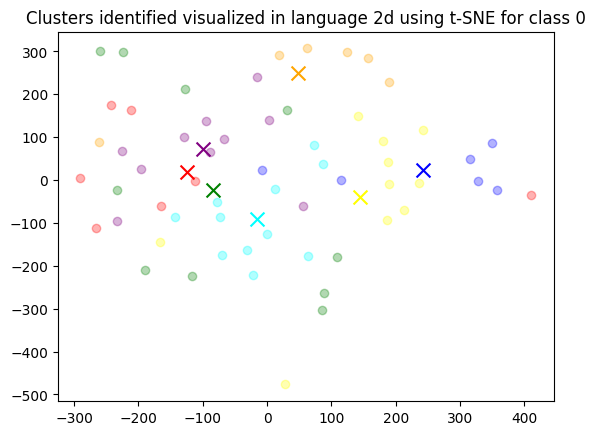

{'CAUSATION': 0, 'CHANGE': 1, 'EXISTENCE': 2, 'NUMBER': 3, 'ORDER': 4, 'QUANTITY': 5, 'RELATION': 6, 'TIME': 7}
[[0, 6], [3, 3], [6, 5], [1, 1], [2, 4], [4, 7], [5, 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.40      0.57      0.47         7
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        11
           4       0.29      0.18      0.22        11
           5       0.00      0.00      0.00         7
           6       0.10      0.17      0.12         6
           7       0.00      0.00      0.00         0

    accuracy                           0.12        60
   macro avg       0.10      0.11      0.10        60
weighted avg       0.11      0.12      0.11        60

[[0 2 0 0 0 2 0 0]
 [0 4 0 0 0 1 1 1]
 [4 1 0 5 1 1 1 1]
 [3 1 0 0 3 2 2 0]
 [1 2 0 1 2 5 0 0]
 [0 0 0 0 1 0 5 1]
 [2 0 0 0 0 0 1 3]
 [0 0 0 0 0 0 0 0]]
Cluster 1 has 3 sections


C:\Users\panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

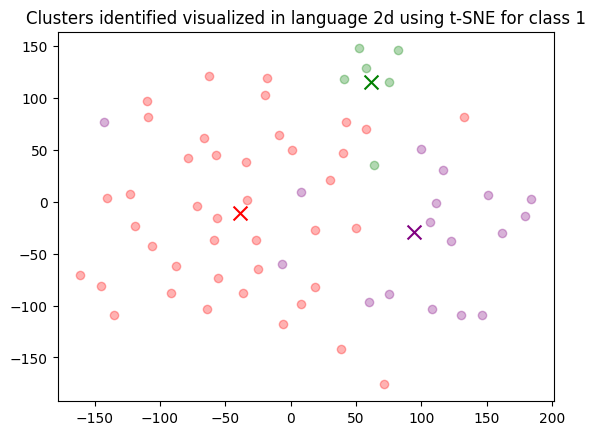

{'INORGANIC MATTER': 0, 'MATTER IN GENERAL': 1, 'ORGANIC MATTER': 2}
[[2, 2], [0, 0], [1, 1]]
              precision    recall  f1-score   support

           0       0.29      0.29      0.29        17
           1       0.00      0.00      0.00         2
           2       0.66      0.60      0.63        45

    accuracy                           0.50        64
   macro avg       0.32      0.30      0.31        64
weighted avg       0.54      0.50      0.52        64

[[ 5  0 12]
 [ 0  0  2]
 [12  6 27]]
Cluster 2 has 4 sections


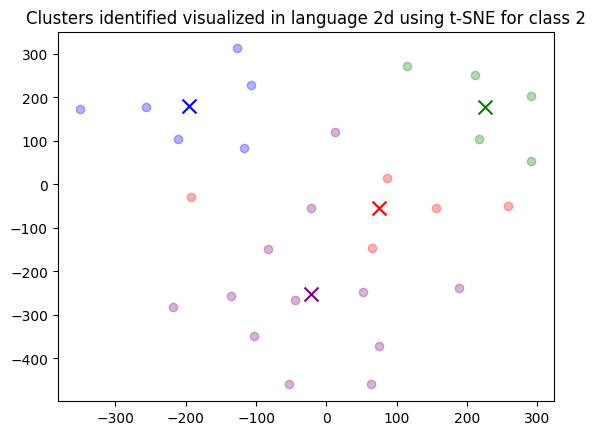

{'DIMENSIONS': 0, 'FORM': 1, 'MOTION': 2, 'SPACE IN GENERAL': 3}
[[0, 0], [1, 1], [3, 3], [2, 2]]
              precision    recall  f1-score   support

           0       0.75      0.56      0.64        16
           1       0.80      0.40      0.53        10
           2       0.00      0.00      0.00         1
           3       0.17      1.00      0.29         1

    accuracy                           0.50        28
   macro avg       0.43      0.49      0.37        28
weighted avg       0.72      0.50      0.57        28

[[9 0 2 5]
 [3 4 3 0]
 [0 1 0 0]
 [0 0 0 1]]
Cluster 3 has 2 divisions


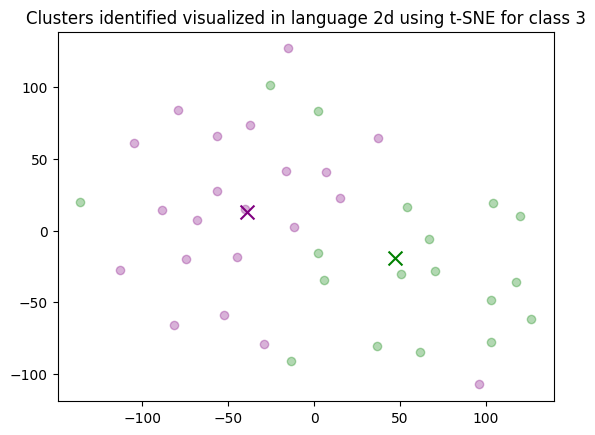

{'COMMUNICATION OF IDEAS': 0, 'FORMATION OF IDEAS': 1}
[[0, 1], [1, 0]]
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        21
           1       0.52      0.61      0.56        18

    accuracy                           0.56        39
   macro avg       0.57      0.57      0.56        39
weighted avg       0.57      0.56      0.56        39

[[11 10]
 [ 7 11]]
Cluster 4 has 5 sections


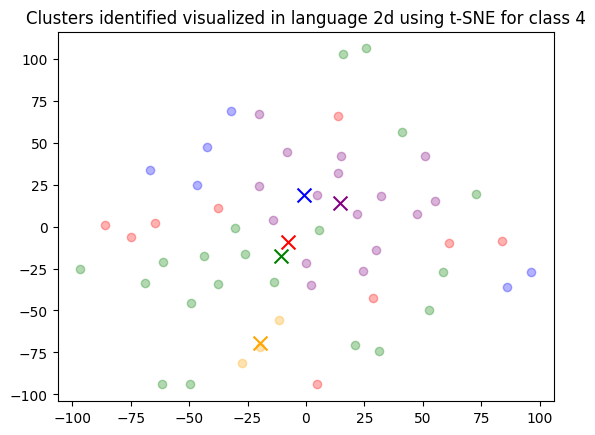

{'AFFECTIONS IN GENERAL': 0, 'MORAL AFFECTIONS': 1, 'PERSONAL AFFECTIONS': 2, 'RELIGIOUS AFFECTIONS': 3, 'SYMPATHETIC AFFECTIONS': 4}
[[0, 4], [1, 2], [2, 1], [3, 3], [4, 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.25      0.29        12
           2       0.40      0.36      0.38        22
           3       0.50      0.75      0.60         4
           4       0.56      0.60      0.58        15

    accuracy                           0.43        54
   macro avg       0.36      0.39      0.37        54
weighted avg       0.43      0.43      0.42        54

[[0 0 1 0 0]
 [0 3 6 2 1]
 [3 4 8 1 6]
 [0 0 1 3 0]
 [0 2 4 0 9]]
Cluster 5 has 2 divisions


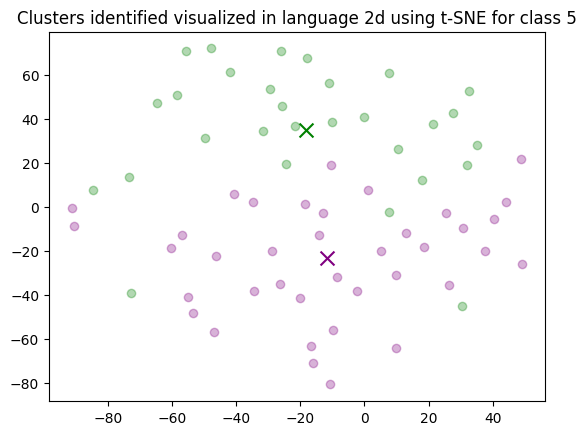

{'INDIVIDUAL VOLITION': 0, 'INTERSOCIAL VOLITION': 1}
[[0, 0], [1, 1]]
              precision    recall  f1-score   support

           0       0.50      0.66      0.57        29
           1       0.66      0.50      0.57        38

    accuracy                           0.57        67
   macro avg       0.58      0.58      0.57        67
weighted avg       0.59      0.57      0.57        67

[[19 10]
 [19 19]]


In [27]:
# Create a for loop that performs KMeans clustering on each class  
for i in range(n_classes):
    # Create a new dataframe with the words and the embeddings that belong to the current label
    new_df = clustering_df[clustering_df['Cluster'] == i].copy()
    
    # Keep only the words that the Cluster column matches the class_num column
    new_df = new_df[new_df['class_num'] == i]

    # See if new_df has division
    div_section = 'section'
    if new_df['division'].nunique() > 1:
        n_clusters = new_df['division'].nunique()
        div_section = 'division'
    else:
        n_clusters = new_df['section'].nunique()

    print(f"Cluster {i} has {n_clusters} {div_section}s")

    # Get the embeddings from the new dataframe
    new_matrix = np.vstack(new_df.embedding.values)

    # Get the min number of words from the section or division distribution
    min_words = new_df[div_section].value_counts().min()
    # Get the max number of words from the section or division distribution
    max_words = new_df[div_section].value_counts().max()

    # Fit the KMeans model to the embeddings
    new_model = KMeansConstrained(n_clusters=n_clusters, n_init=100, max_iter=100, random_state=62,
                                  size_min=min_words, size_max=max_words, n_jobs=-1)
    new_model.fit(new_matrix)
    # Get the cluster labels
    new_labels = new_model.labels_
    # Add the cluster labels to the new dataframe
    new_df["Cluster"] = new_labels

    draw_clusters(new_df, f"Clusters identified visualized in language 2d using t-SNE for class {i}", n_clusters,
                  new_matrix)

    # Create a dynamic hierarchy based on the class (not the cluster that is matched to the class) that we are currently working on
    dynamic_hierarchy = create_dynamic_hierarchy(clustering_df[clustering_df['class_num'] == i].copy(), 'class', 'division', 'section', 'word')

    #print(dynamic_hierarchy)

    # Create category_index based on dynamic_hierarchy
    category_index = create_category_index(dynamic_hierarchy)
    # Sort the category index alphabetically and create a new dictionary so the numbers are in order
    category_index = dict(sorted(category_index.items(), key=lambda item: item[0]))
    #create a new dictionary so the numbers are in order
    category_index = {k: v for v, k in enumerate(category_index)}

    print(category_index)

    # Get the most similar roget class for each extracted class
    predicted_labels = cluster_checking(new_model, new_df, categories, category_index, isClass=False)

    # Determine the column name for the division or section
    div_section_num = div_section + '_num'

    # Add the classes in numeric categories to the new dataframe
    new_df[div_section_num] = pd.Categorical(new_df[div_section])
    new_df[div_section_num] = new_df[div_section_num].cat.codes
    # Remap the labels using the relation list we got from the previous function
    new_df['Cluster'] = predicted_labels

    # Print the classification report and the confusion matrix
    print(classification_report(new_df[div_section_num], new_df['Cluster']))
    print(confusion_matrix(new_df[div_section_num], new_df['Cluster']))

#### Conclusion

We can see that the two level clustering has a high degree of mismatch with the roget divisions/sections of each class as well.
In this case the mismatch is even higher than the one-level clustering, which is expected given the high degree of imbalance in the classes and the divisions/sections,
which explains the extremely low precision and recall in some cases (0.0).

However, when look at the divisions in particular (which are always fewer than the sections), we can see that the precision and recall are higher than the sections,
which gives us a hint that the two level clustering is better at matching the roget divisions than the roget sections.

Also, seeing the t-SNE plots for each one-level cluster, we can see that the cluster centroids are still not well separated, which is expected given the high degree of imbalance in the classes and the divisions/sections. The exception stands for the divisions, which are always fewer than the sections, and the t-SNE plots for the divisions show a better separation of the cluster centroids.